MODEL 3 - COLLABORATIVE_FILTERING

***

In [1]:
# load packages 
import pandas as pd
import numpy as np

# float format
pd.options.display.float_format = '{:,}'.format


from keras.layers import Embedding, Input, dot, concatenate
from keras.models import Model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [2]:

#mount drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load data

#path = '/content/drive/MyDrive/Colab Notebooks/VVNM/data_cleaning.csv' 
path = '/content/drive/MyDrive/Colab Notebooks/data_cleaning.csv' 
movies_data = pd.read_csv(path)

movies_data = movies_data.drop(['Unnamed: 0'],axis = 1)

print(movies_data.shape)
movies_data.head(4)

(1697179, 15)


,USER_KEY,USER_NAME,USER_AGE,USER_SEX,VIEW_DATE,ASSET_TYPE,ASSET_CATEGORY,SRC_GENRE_DESC,CHANNEL,ASSET_NAME,PRG_DURATION_MIN,VIEW_DURATION_MIN,VIEWERSHIP_KEY,ASSET_KEY,VIEW_RATING
0,489647,A98815,73,F,10/12/18 00:00:00,LIVE TV,SPORTS,SPORTS-LIVE,ΕΡΤ1,Super League SOUROTI 2018/19 (L)(PANAITOLIKOS ...,115,"17,5",8769,6548,1
1,489647,A98815,73,F,10/12/18 00:00:00,TSTV,SPORTS,SPORTS-LIVE,"Eurosport 1 (International, GREEK)",Sports show (ALL SPORTS: WATTS ),15,"12,83",8770,7633,4
2,490873,babil,30,F,10/12/18 00:00:00,LIVE TV,SPORTS,SPORTS-LIVE,novasports1 HD,Greek Football Championship 2018/19 (L)(PANION...,130,"23,27",8771,7634,1
3,488305,9anti1,29,M,10/12/18 00:00:00,LIVE TV,SPORTS,SPORTS-LIVE,novasports1 HD,Greek Football Championship 2018/19 (L)(PANION...,130,"73,95",8772,7634,3


In [5]:
#check for user '99802622'
movies_data.loc[movies_data['USER_NAME'] == '99802622'].head(10)

,USER_KEY,USER_NAME,USER_AGE,USER_SEX,VIEW_DATE,ASSET_TYPE,ASSET_CATEGORY,SRC_GENRE_DESC,CHANNEL,ASSET_NAME,PRG_DURATION_MIN,VIEW_DURATION_MIN,VIEWERSHIP_KEY,ASSET_KEY,VIEW_RATING
94179,6000290,99802622,71,M,12/12/18 00:00:00,VOD,CHRISTMAS TIME,FAMILY,UNKNOWN,A NUTCRACKER CHRISTMAS,"61,776","47,52",102948,1093,4
371951,6000290,99802622,71,M,17/12/18 00:00:00,VOD,CHRISTMAS TIME,ROMANCE,UNKNOWN,A CHRISTMAS TO REMEMBER,"22,945","17,65",380720,4925,4
429839,6000290,99802622,71,M,17/12/18 00:00:00,VOD,CHRISTMAS TIME,TRUE STORY,UNKNOWN,THE GREATEST SHOWMAN,"207,35","159,5",438608,79,4
522886,6000290,99802622,71,M,20/12/18 00:00:00,VOD,MOVIES,"ACTION,CRIME",UNKNOWN,UNDISPUTED 4,"74,061","56,97",531655,5000,4
538005,6000290,99802622,71,M,19/12/18 00:00:00,VOD,MOVIES,"COMEDY,CRIME",UNKNOWN,HOT PURSUIT,"72,28","55,6",546774,1706,4
548073,6000290,99802622,71,M,20/12/18 00:00:00,VOD,MOVIES,"CRIME,MYSTERY",UNKNOWN,MURDER ON THE ORIENT EXPRESS,"32,539","25,03",556842,2223,4
556259,6000290,99802622,71,M,21/12/18 00:00:00,VOD,MOVIES,"CRIME,SCIFI",UNKNOWN,ROBOCOP,"192,686","148,22",565028,1694,4
640801,6000290,99802622,71,M,23/12/18 00:00:00,VOD,MOVIES,"CRIME,THRILLER",UNKNOWN,THE HYPNOTIST,"66,196","50,92",649570,8300,4
653789,6000290,99802622,71,M,22/12/18 00:00:00,VOD,CHRISTMAS TIME,ROMANTIC COMEDY,UNKNOWN,SILVER LININGS PLAYBOOK,"13,416","10,32",662558,3921,4
665698,6000290,99802622,71,M,22/12/18 00:00:00,VOD,MOVIES,ADVENTURE,UNKNOWN,"10,000 B.C.","14,456","11,12",674467,4513,4


In [6]:
movies_data.ASSET_CATEGORY.unique

<bound method Series.unique of 0                  SPORTS
1                  SPORTS
2                  SPORTS
3                  SPORTS
4                  MOVIES
                ...      
1697174            MOVIES
1697175            MOVIES
1697176              KIDS
1697177    CHRISTMAS TIME
1697178            MOVIES
Name: ASSET_CATEGORY, Length: 1697179, dtype: object>

In [7]:
# Create a function to find genres in the dataset

genres = {} # create a dictionary to store different genre values

def find_genres():
    for genre in movies_data['SRC_GENRE_DESC']:
        words = genre.split(',')
        for word in words:
            genres[word] = genres.get(word, 0) + 1
            
find_genres()

In [8]:
genres

{'ACTION': 179184,
 'ADVENTURE': 41629,
 'ANIMATION': 88126,
 'COMEDY': 194529,
 'COMEDY DRAMA': 21332,
 'COOKING': 4315,
 'CRIME': 153617,
 'DOCUMENTARY': 28315,
 'DRAMA': 105440,
 'FAMILY': 76414,
 'FANTASY': 24379,
 'HISTORY': 8711,
 'HORROR': 51922,
 'KIDS': 288522,
 'LIVE ACTION': 25981,
 'MEDICAL DRAMA': 8013,
 'MUSICAL': 1076,
 'MYSTERY': 54067,
 'REALITY SHOW': 23820,
 'ROMANCE': 21962,
 'ROMANTIC COMEDY': 55733,
 'SCIFI': 38030,
 'SHOW': 35298,
 'SOCIAL': 41262,
 'SPORT': 6858,
 'SPORTS-LIVE': 200892,
 'TALENT SHOW': 11225,
 'THRILLER': 144595,
 'TRUE STORY': 60926,
 'UNKNOWN': 104264,
 'WAR': 11207,
 'WESTERN': 3080}

In [9]:
#Heavily Rated Movies

ratings = pd.DataFrame(round(movies_data.groupby('ASSET_NAME')['VIEW_RATING'].mean(),1))
ratings['total ratings'] = pd.DataFrame(movies_data.groupby('ASSET_NAME')['VIEW_RATING'].count())

ratings.rename(columns = {'VIEW_RATING': 'mean ratings'}, inplace=True)
ratings.sort_values('total ratings', ascending=False).head(10)

,mean ratings,total ratings
ASSET_NAME,,
HOME ALONE,4.0,25135
UNKNOWN,4.0,25064
Sports program (L)(SUPER EUROLEAGUE),1.6,23982
FERDINAND (GREEK DUBBED),4.0,23388
RED SPARROW,4.0,16844
MY LITTLE PONY: THE MOVIE (GREEK DUBBED),4.0,15926
THE BIG BAD FOX AND OTHER TALES (GREEK DUBBED),4.0,15396
PETER RABBIT (GREEK DUBBED),4.0,14154
CHRISTMAS & CO. (GREEK DUBBED),4.0,14015


In [10]:
#Highily Rated Movies

ratings.sort_values('mean ratings', ascending=False).head(10)

,mean ratings,total ratings
ASSET_NAME,,
Comedy series - Ep. 24(STUCK IN THE MIDDLE),5.0,1
Travel documentary - Ep. 10 (R)(OF STONE AND TIME),5.0,2
Million Dollar Manor(BID AND DESTROY ),5.0,1
Motorized sports (R)(MOTORSPORTS: TEST DRIVE),5.0,3
"Mystery - Horror series, Episode 10 (CASTLE ROCK )",5.0,3
Nature - Anthropology - Ep. 4 (R)(ON THE MOUNTAINS),5.0,2
Comedy Series - Ep. 5 (BOB'S BURGERS 6 ),5.0,2
Brigitte Fitness Intensive(FITNESS TIME),5.0,1
Braille Typewriters/Carbon Fibre Cello(HOW IT'S MADE? 7),5.0,3


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


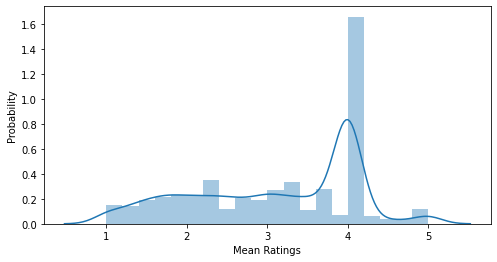

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,4))
sns.distplot(ratings['mean ratings'], bins=20)
plt.xlabel('Mean Ratings')
plt.ylabel('Probability')
plt.show()

**Item Based Collaborative Filtering**

***


Collaborative filtering is the process of filtering for information or patterns using techniques involving collaboration among multiple agents, viewpoints, data sources.Basically, it is a method of making automatic predictions (filtering) about the interests of a user by collecting preferences or taste information from many users.

Item Based Collaborative Filtering: Users who viewed **this** also viewed **this**.

In [12]:
data = movies_data.copy()
data = data.loc[data['ASSET_CATEGORY'] == 'MOVIES']
data.shape

(624050, 15)

In [13]:
#Keep only the below columns
data = data[['USER_NAME','ASSET_NAME','VIEW_RATING']]
data.shape
data.tail(5)

,USER_NAME,ASSET_NAME,VIEW_RATING
1697166,OTT_17XPZ1UI,SLAMMA JAMMA,4
1697173,OTT_128XNR4Y,THE 15:17 TO PARIS,4
1697174,OTT_12CGUWBK,AMITYVILLE: THE AWAKENING,4
1697175,OTT_14DP195L,WRATH OF THE TITANS,4
1697178,OTT_12L49R0P,TRACKTOWN,4


In [14]:
data.describe()

,VIEW_RATING
count,"624,050.0"
mean,3.8633042224180754
std,0.6506178336139647
min,1.0
25%,4.0
50%,4.0
75%,4.0
max,6.0


In [15]:
group_data = data.pivot_table(index = 'USER_NAME', columns = 'ASSET_NAME', values = 'VIEW_RATING')
group_data.shape
group_data

ASSET_NAME,THE COMMUNE,"10,000 B.C.",13 GOING ON 30,15 MINUTES,150 MILLIGRAMS,2001: A SPACE ODYSSEY,2012,21,22 JUMP STREET,22Jump_Street FINAL 29/10,24 HOURS TO LIVE,300,50 FIRST DATES,A CLOCKWORK ORANGE,"A CRAZY, CRAZY 40-YEAR-OLD","A CRAZY, CRAZY FAMILY",A DASH OF LOVE,A DATE IN THE SKY,A DEADLY VIEW,A DOG`S PURPOSE,A FEW LESS MEN,A FISH TALE,A GREEK WOMAN IN THE HAREM,A HAPPY BEGINNING,A LADY AT THE BOUZOUKI JOINTS,A LAW-ABIDING CITIZEN,A MATTER OF CONSCIENCE,A Natural Fit For a Fun Family(POOL KINGS 3),A SMART GUY,A STAR IS BORN,A TANK ON MY BED,A VERY CLEVER GUY,A WOMAN'S PAST,ABOUT SCHMIDT,ABUSE OF POWER,ACANTILADO,ACCIDENT MAN,ACTS OF VENGEANCE,ACTS OF VENGEANCE,ADMISSION,...,VACATION IN VIETNAM,VALENTINE'S DAY,VALERIAN,VALERIAN,VALKYRIE,VANTAGE POINT,VASOULA AND THE BASES,VENGEANCE: A LOVE STORY,VERTIGO,VINTAGE & THE VINEYARD SECRETS BOX SETS,VOWS OF DECEIT,"WAKE UP, VASSILIS!",WAKEFIELD,WAR FOR THE PLANET OF THE APES,WE ARE MARSHALL,WE BOUGHT A ZOO,WE ONLY HAVE ONE LIFE,WEDDING NIGHT,WEDDING WONDERLAND,WHAT HAPPENED TO MONDAY,WHEN THE CITY DIES,WHITE HOUSE DOWN,WINCHESTER,WIND RIVER,WITH FEAR AND PASSION,WITHIN,WITHOUT IDENTITY,WITNESS UNPROTECTED,WONDER WOMAN,WOODSHOCK,WRATH OF THE TITANS,War (PLATOON ),Western (THE MAGNIFICENT SEVEN ),Wish-A-Pawn A Star(PAWN STARS),ZERO VISIBILITY,ZOOKEEPER,cont dol,ΕP.2 DRAIN THE OCEANS,ΠΕΘΑΊΝΩ ΓΙΑ ΣΈΝΑ,ΤΟ ΞΎΠΝΗΜΑ ΤΗΣ ΆΝΟΙΞΗΣ
USER_NAME,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
.,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
11500020,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
12000244,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
99802619,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
99802622,nan,4.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,4.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zrepcom,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
zrmanos,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,n

In [16]:
# Item based Collaborative filtering

group_data_matrix = group_data.copy()

# We will fill the column wise NaN's with the corresponding movie's mean ratings, so that we can carry out Pearson correlation.
# Here we assume avg ratings for the user that has not a rated movie.

group_data_matrix = group_data_matrix.apply(lambda col: col.fillna(col.mean()), axis=1)
group_data_matrix.head(5)

ASSET_NAME,THE COMMUNE,"10,000 B.C.",13 GOING ON 30,15 MINUTES,150 MILLIGRAMS,2001: A SPACE ODYSSEY,2012,21,22 JUMP STREET,22Jump_Street FINAL 29/10,24 HOURS TO LIVE,300,50 FIRST DATES,A CLOCKWORK ORANGE,"A CRAZY, CRAZY 40-YEAR-OLD","A CRAZY, CRAZY FAMILY",A DASH OF LOVE,A DATE IN THE SKY,A DEADLY VIEW,A DOG`S PURPOSE,A FEW LESS MEN,A FISH TALE,A GREEK WOMAN IN THE HAREM,A HAPPY BEGINNING,A LADY AT THE BOUZOUKI JOINTS,A LAW-ABIDING CITIZEN,A MATTER OF CONSCIENCE,A Natural Fit For a Fun Family(POOL KINGS 3),A SMART GUY,A STAR IS BORN,A TANK ON MY BED,A VERY CLEVER GUY,A WOMAN'S PAST,ABOUT SCHMIDT,ABUSE OF POWER,ACANTILADO,ACCIDENT MAN,ACTS OF VENGEANCE,ACTS OF VENGEANCE,ADMISSION,...,VACATION IN VIETNAM,VALENTINE'S DAY,VALERIAN,VALERIAN,VALKYRIE,VANTAGE POINT,VASOULA AND THE BASES,VENGEANCE: A LOVE STORY,VERTIGO,VINTAGE & THE VINEYARD SECRETS BOX SETS,VOWS OF DECEIT,"WAKE UP, VASSILIS!",WAKEFIELD,WAR FOR THE PLANET OF THE APES,WE ARE MARSHALL,WE BOUGHT A ZOO,WE ONLY HAVE ONE LIFE,WEDDING NIGHT,WEDDING WONDERLAND,WHAT HAPPENED TO MONDAY,WHEN THE CITY DIES,WHITE HOUSE DOWN,WINCHESTER,WIND RIVER,WITH FEAR AND PASSION,WITHIN,WITHOUT IDENTITY,WITNESS UNPROTECTED,WONDER WOMAN,WOODSHOCK,WRATH OF THE TITANS,War (PLATOON ),Western (THE MAGNIFICENT SEVEN ),Wish-A-Pawn A Star(PAWN STARS),ZERO VISIBILITY,ZOOKEEPER,cont dol,ΕP.2 DRAIN THE OCEANS,ΠΕΘΑΊΝΩ ΓΙΑ ΣΈΝΑ,ΤΟ ΞΎΠΝΗΜΑ ΤΗΣ ΆΝΟΙΞΗΣ
USER_NAME,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
.,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
11500020,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,...,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5
12000244,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
99802619,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
99802622,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0


In [17]:
group_data_matrix.isna().sum().sum()

0

In [18]:
group_data_matrix = group_data_matrix.corr()
group_data_matrix

ASSET_NAME,THE COMMUNE,"10,000 B.C.",13 GOING ON 30,15 MINUTES,150 MILLIGRAMS,2001: A SPACE ODYSSEY,2012,21,22 JUMP STREET,22Jump_Street FINAL 29/10,24 HOURS TO LIVE,300,50 FIRST DATES,A CLOCKWORK ORANGE,"A CRAZY, CRAZY 40-YEAR-OLD","A CRAZY, CRAZY FAMILY",A DASH OF LOVE,A DATE IN THE SKY,A DEADLY VIEW,A DOG`S PURPOSE,A FEW LESS MEN,A FISH TALE,A GREEK WOMAN IN THE HAREM,A HAPPY BEGINNING,A LADY AT THE BOUZOUKI JOINTS,A LAW-ABIDING CITIZEN,A MATTER OF CONSCIENCE,A Natural Fit For a Fun Family(POOL KINGS 3),A SMART GUY,A STAR IS BORN,A TANK ON MY BED,A VERY CLEVER GUY,A WOMAN'S PAST,ABOUT SCHMIDT,ABUSE OF POWER,ACANTILADO,ACCIDENT MAN,ACTS OF VENGEANCE,ACTS OF VENGEANCE,ADMISSION,...,VACATION IN VIETNAM,VALENTINE'S DAY,VALERIAN,VALERIAN,VALKYRIE,VANTAGE POINT,VASOULA AND THE BASES,VENGEANCE: A LOVE STORY,VERTIGO,VINTAGE & THE VINEYARD SECRETS BOX SETS,VOWS OF DECEIT,"WAKE UP, VASSILIS!",WAKEFIELD,WAR FOR THE PLANET OF THE APES,WE ARE MARSHALL,WE BOUGHT A ZOO,WE ONLY HAVE ONE LIFE,WEDDING NIGHT,WEDDING WONDERLAND,WHAT HAPPENED TO MONDAY,WHEN THE CITY DIES,WHITE HOUSE DOWN,WINCHESTER,WIND RIVER,WITH FEAR AND PASSION,WITHIN,WITHOUT IDENTITY,WITNESS UNPROTECTED,WONDER WOMAN,WOODSHOCK,WRATH OF THE TITANS,War (PLATOON ),Western (THE MAGNIFICENT SEVEN ),Wish-A-Pawn A Star(PAWN STARS),ZERO VISIBILITY,ZOOKEEPER,cont dol,ΕP.2 DRAIN THE OCEANS,ΠΕΘΑΊΝΩ ΓΙΑ ΣΈΝΑ,ΤΟ ΞΎΠΝΗΜΑ ΤΗΣ ΆΝΟΙΞΗΣ
ASSET_NAME,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
THE COMMUNE,1.0,0.9993218511222767,1.0,0.999948742902185,0.9999398968711161,0.9986737225321204,0.9995425214375852,0.9999990304145816,0.9986713359783536,0.9999868061637053,0.9974209904092174,0.9977131900129422,0.9998253637456035,0.9993078780123833,0.9999250416246961,0.9999599954127896,0.9998140582492987,0.9999341668856672,0.9996609254107903,0.9999053446185433,0.9998788765894435,0.9999269062917446,0.999924062811673,0.9999955700489682,0.9999486014295139,0.9999465968587783,0.9998742774969748,0.9997575779086164,0.9998270623309081,0.9997889092778759,0.9999314103217012,0.99994916807079,0.9999926752980791,0.9996986348180157,0.9999490370259743,0.9999178391813786,0.997925472337089,0.9971858818343579,1.0,0.9981917520134621,...,0.9999422312914122,0.9998219737710725,0.999557368041739,1.0,0.9989616325446299,1.0,0.9999982329307109,0.9990552063056872,0.9999833794985329,0.9999976919901894,0.9998512846476786,0.9998892739474867,0.9999428555681324,0.9993111780148077,0.9994865044117837,0.9997634987787815,0.9999493634946616,0.9998334522128272,0.9997435584200316,0.9997625030210029,1.0,0.9989164209429007,0.9988520248690504,0.9998270988265145,0.999981304963344,0.9998386900031694,0.999992681614382,0.999871079862259,0.9972844334118846,0.9999519602355077,0.9985979674588998,0.996368794400234,0.9929482564900619,0.9993927554508655,0.9999469688266878,0.9992418811151478,1.0,0.9999490872645735,0.9998408677262756,0.9998773153295835
"10,000 B.C.",0.9993218511222767,1.0,0.9993218511222767,0.999270473038335,0.999261624897979,0.9980216907068025,0.99888980218127,0.9993208779619664,0.9980310542657546,0.9993086247010627,0.9968190846824155,0.9971654009377708,0.999148071069953,0.9986744511823902,0.9992467398179634,0.9992817620318476,0.9991355180631026,0.9992558907785506,0.998982070430634,0.9992281949502368,0.9992004834787931,0.9992485942525989,0.9992457480809004,0.9993174100535341,0.999270361831057,0.9992683323796064,0.9991958929979249,0.999079878967337,0.9991497789943679,0.9991277669118813,0.9992531154928815,0.9992709036887427,0.9993145087244222,0.999032195109359,0.999271978506771,0.9992395181168416,0.9972475612028304,0.9965231363353172,0.9993218511222767,0.9976401918499416,...,0.9992639722713658,0.9991434622525482,0.9988967460270551,0.9993218511222767,0.9983770938882379,0.9993218511222767,0.9993200785510699,0.9984255010862225,0.9993051909416204,0.9993195363992937,0.9991839710693928,0.9992109077252936,0.9992645893669276,0.9986950254264697,0.9988300089727832,0.999084872691798,0.9992711144931976,0.9991549651582413

The user enters a movie name and the most relevant movies are returned.

In [19]:
movie_input = input("Enter the name of the movie or serie:")

#movie_corr = movie_input
movie_corr = group_data_matrix[movie_input]
movie_corr = movie_corr.sort_values(ascending=False)
movie_corr.dropna(inplace=True)
movie_corr


movies_similar_to = pd.DataFrame(data=movie_corr.values, columns=['Correlation'], index = movie_corr.index)
movies_similar_to = movies_similar_to.join(ratings['total ratings'])

movies_similar_to = movies_similar_to[1:]
movies_similar_to[ movies_similar_to['total ratings'] > 100 ].sort_values(ascending=False, by=['Correlation']).head(10)

Enter the name of the movie or serie:THE COMMUNE


,Correlation,total ratings
ASSET_NAME,,
THE COMMUNE,0.9997631224347492,119
"TELLE MERE, TELLE FILLE",0.9997631224347492,426
BACK TO BURGUNDY,0.9997631224347492,210
WHEN THE CITY DIES,0.9997631224347492,114
VALERIAN,0.9997631224347492,489
ACTS OF VENGEANCE,0.9997631224347492,10896
TWO IS A FAMILY,0.9997631224347492,359
SEE YOU UP THERE,0.9997631224347492,229
LES HOMMES DU FEU,0.9997631224347492,129
